In [1]:
import requests
from time import sleep

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
URL = 'http://35.180.178.243'
key = "64K3WR50NI1W00Q9TSXV"

In [3]:
def reset(key):
    r = requests.get(url=URL+'/reset', 
                 params = { 
                     'user_id':key,
                 })
    return r.json()

def predict(key, predicted_score):
    r = requests.get(url=URL + '/predict', 
                 params = { 
                     'user_id':key,
                     'recommended_item':predicted_score 
                 })
    return r.json()

def print_stats_with_CI(rewards_for_several_runs):
    f, (ax1) = plt.subplots(1, 1, sharey=False, figsize=(16, 8))
    
    cumsum_rewards = []
    for i, rewards in enumerate(rewards_for_several_runs):
        
        cumsum_reward = np.cumsum(rewards)
        cumsum_rewards.append(cumsum_reward)
        ax1.plot(cumsum_reward, label='cum reward for run = %d' % i)
    
    ax1.legend();
    
    mean = np.mean(cumsum_rewards, axis=0)
    ub = np.min(cumsum_rewards, axis=0)
    lb = np.max(cumsum_rewards, axis=0)
        
    plt.figure(figsize=(10, 10))
    plt.fill_between(range(mean.shape[0]), ub, lb,
                     color='k', alpha=.5)
    # plot the mean on top
    plt.plot(mean, 'k')

In [4]:
history = reset(key)

In [5]:
history.keys()

dict_keys(['action_history', 'nb_items', 'nb_users', 'next_state', 'rewards_history', 'state_history'])

In [6]:
t = 0

obs = np.array(history['state_history'][t])
r = np.array(history['rewards_history'][t])

next_obs = np.array(history['state_history'][t+1])
a = np.array(history['action_history'][t])

In [7]:
state = obs[0, 3:5]
possible_items = obs[:, 5:]
action = possible_items[a]

next_state = next_obs[0, 3:5]
next_possible_items = next_obs[:, 5:]


In [8]:
exp_replay_entries = []
for t in range(len(history['rewards_history']) - 1):
    obs = np.array(history['state_history'][t])
    r = np.array(history['rewards_history'][t])

    next_obs = np.array(history['state_history'][t+1])
    a = np.array(history['action_history'][t])
    
    state = obs[0, 3:5]
    possible_items = obs[:, 5:]
    action = possible_items[a]

    next_state = next_obs[0, 3:5]
    next_possible_items = next_obs[:, 5:]
    
    experience = (state, action, r, next_state, next_possible_items, False)
    exp_replay_entries.append(experience)

last_state = state
last_action = action


In [9]:
reward = r

raw_obs = np.array(history['next_state'])

observation = (raw_obs[0, 3:5], raw_obs[:, 5:])

In [18]:
def fill_history_and_train(history, ddpg_agent):
    exp_replay_entries = []
    for t in range(len(history['rewards_history']) - 1):
        obs = np.array(history['state_history'][t])
        r = np.array(history['rewards_history'][t])

        next_obs = np.array(history['state_history'][t+1])
        a = np.array(history['action_history'][t])

        state = obs[0, 3:5]
        possible_items = obs[:, 5:]
        action = possible_items[a]

        next_state = next_obs[0, 3:5]
        next_possible_items = next_obs[:, 5:]

        experience = (state, action, r, next_state, next_possible_items, False)
        exp_replay_entries.append(experience)

    last_state = state
    last_action = action
    
    ## 
    for exp in exp_replay_entries:
        ddpg_agent._replay.store(exp)
    
    ddpg_agent._last_state = state
    ddpg_agent._last_action = action

    
def get_obs_from_raw_obs(raw_obs): 
    observation = (raw_obs[0, 3:5], raw_obs[:, 5:])
    return observation

In [45]:
import tensorflow as tf 
from agents.ddpg import DDPGAgent
from rec_gym.runner import run_experiment
from copy import deepcopy
import gin

In [46]:

state_dim = 2
action_dim = 3
action_size = 1

In [47]:
%%time
n_runs = 10
rewards_for_several_runs = []

for i in range(n_runs):
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    gin.parse_config("""""")
    agent = DDPGAgent(action_size = action_size,
                 state_dim = state_dim,
                 action_dim = action_dim,
                 gamma = .9,
                 sess = sess,
                 optimizer = tf.train.AdamOptimizer(
                     learning_rate=0.01
                 ),
                 max_tf_checkpoints_to_keep = 3,
                 experience_size = 300,
                 per = True,
                 batch_size = 64, 
                 start_steps = 400)
    sess.run(tf.global_variables_initializer())
    
    history = reset(key)
    
    fill_history_and_train(history, agent)
    
    obs = get_obs_from_raw_obs(np.array(history['next_state']))
        
    rs = []
    for i in tqdm_notebook(range(100)):
        sleep(0.05)
        
        if i == 0:
            prediction = agent.begin_episode(obs)
        else:
            prediction = agent.step(r, obs)
            
        res = predict(key, prediction)

        obs = get_obs_from_raw_obs(np.array(res['state']))
        r = res['reward']

        rs.append(r)
        
    rewards_for_several_runs.append(rs)

/home/anton/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


/media/anton/0b9d5a44-bb63-4de1-9cfe-0da47b81e88a/TPT/3A/PRIM Vente Privee/rec_gym/agents/utils.py:275: RuntimeWarning: divide by zero encountered in double_scalars
  max_weight = (p_min * n) ** (-self.PER_b)



CPU times: user 1min 13s, sys: 5.89 s, total: 1min 19s
Wall time: 2min 53s


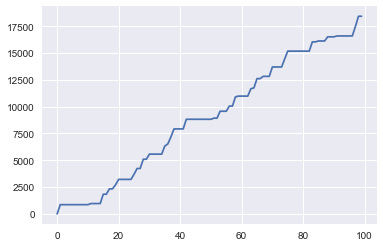

In [35]:
plt.plot(np.cumsum(rs))

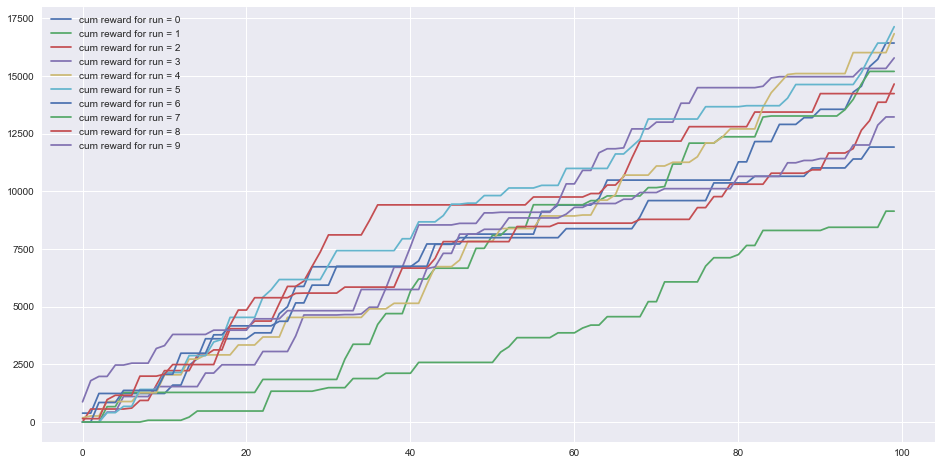

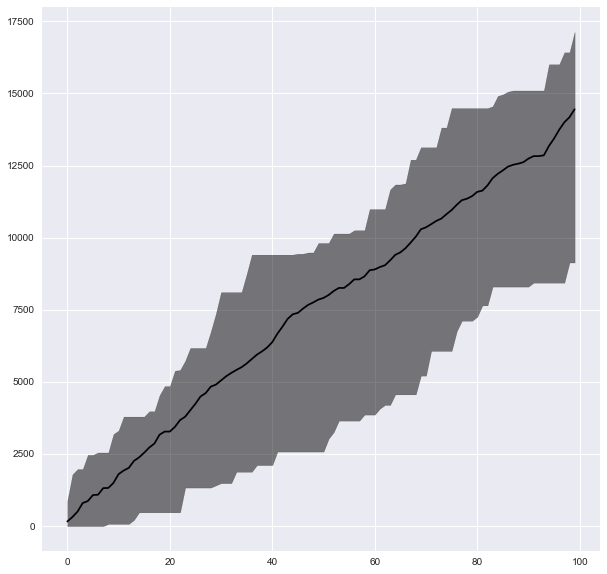

In [48]:
print_stats_with_CI(rewards_for_several_runs)